In [1]:
using DrWatson
@quickactivate "momdist"

In [2]:
using PersistenceDiagrams, PersistenceDiagramsBase, Ripserer
using Distributions, Distances, JLD2, LinearAlgebra, Parameters, Pipe, Plots
using LazySets, LambertW, ProgressMeter, Random, Statistics, StatsPlots

import RobustTDA as rtda

In [3]:
ProgressMeter.ijulia_behavior(:warn)
theme(:dao)

In [4]:
function randomRotation(; d=3)
    A = randn(d, d)
    M = (A + A') ./ √2
    _, U = eigen(M)
    return U
end

function interlockedCircles(n; args...)
    R = [1 0 0; 0 0 -1; 0 1 0]
    X1 = [[x...; 0] for x in rtda.randCircle(n)]
    X2 = [R * ([x...; 0] .+ [1.0, 0.0, 0.0]) for x in rtda.randCircle(n)]
    return [X1; X2]
end

interlockedCircles (generic function with 1 method)

In [5]:
begin
    Random.seed!(2022)
    m = 150
    n = 7 * m
    dim = 10
    R = randomRotation(d=dim)

    points = interlockedCircles(n)
    signal = [Tuple(R * [x...; zeros(dim - 3)]) for x in points]

    l = 1
    win = (-l, l, -l, l)
    R = product_distribution(repeat([Uniform(-1, 1)], dim))
    noise = [rand(R) for _ in 1:m]

    X = [signal; noise]
    Xn = [[x...] for x in X]
end;

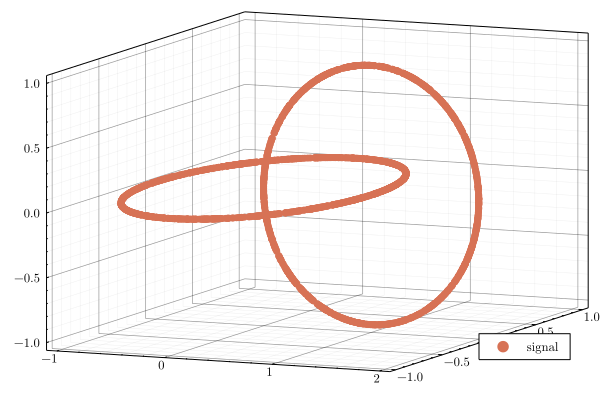

In [6]:
scatter(Tuple.(points), ratio=1, label="signal", legend=:bottomright)

In [7]:
# Initialize Lepski Parameters
θ = rtda.lepski_params(
    a=0.1,
    b=1,
    mmin=100,
    mmax=500,
    pi=1.15,
    δ=0.01
)

# Calibration
M = rtda.lepski(Xn=Xn, params=θ)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /storage/home/s/suv87/work/julia_depot/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:01:36
  m:  266

266

In [8]:
# Refined Lepski
θ = rtda.lepski_params(
    a=0.2,
    b=1,
    mmin=round(Int, 0.5 * M),
    mmax=round(Int, 1 * M),
    pi=1.07,
    δ=0.01
)
M = rtda.lepski(Xn=Xn, params=θ)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /storage/home/s/suv87/work/julia_depot/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress: 100%|█████████████████████████████████████████| Time: 1:36:25
  m:  245


262

In [9]:
theme(:default)

In [10]:
Q = 2 * M + 1
dnq = rtda.momdist(Xn, floor(Int, Q))
w_momdist = rtda.fit(Xn, dnq)
D1 = rtda.wrips(Xn, w=w_momdist, p=1)

2-element Vector{PersistenceDiagram}:
 2250-element 0-dimensional PersistenceDiagram
 6-element 1-dimensional PersistenceDiagram

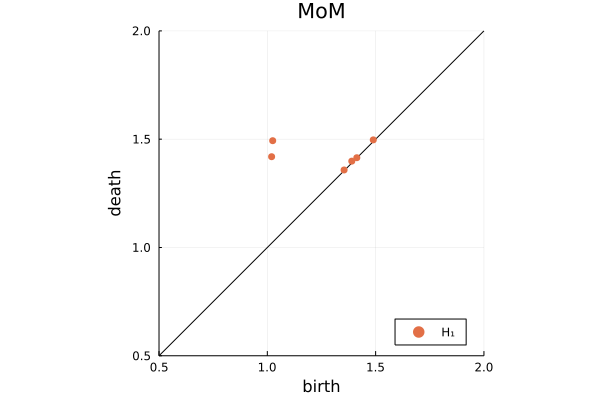

In [11]:
plot(D1[2], title="MoM", lim=(0.5, 2), markeralpha=1)

In [12]:
dnm = rtda.dtm(Xn, Q / n)
w_dtm = rtda.fit(Xn, dnm)
D2 = rtda.wrips(Xn, w=w_dtm, p=1)

2-element Vector{PersistenceDiagram}:
 2250-element 0-dimensional PersistenceDiagram
 5-element 1-dimensional PersistenceDiagram

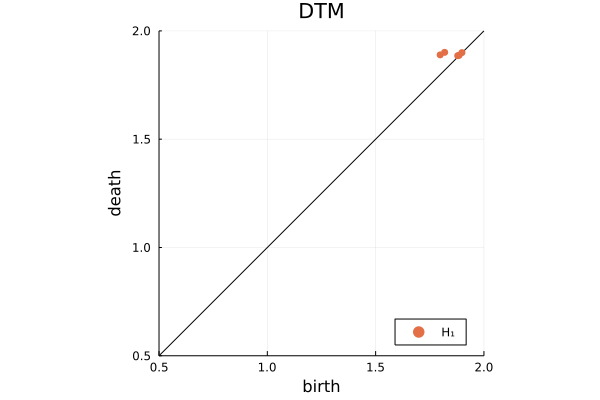

In [13]:
plot(D2[2], title="DTM", lim=(0.5, 2), markeralpha=1)